In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "sans-serif"

In [3]:
data = pd.read_csv('./Data/STA160_Midterm_Data_Processed.csv', dtype={'Response': str})

In [4]:
columns = list(data.columns)
categorical_vars = columns[:3] + columns[4:-1]

# Age Grouping

In [5]:
gen1 = []
gen2 = []
gen3 = []
gen4 = []
gen5 = []

for age_group in sorted(data['Age'].unique()):
    data_age_group = data[data['Age'] == age_group]

    proportions = data_age_group['GenHlth'].value_counts(normalize=True).sort_index()

    gen1.append(proportions.iloc[0])
    gen2.append(proportions.iloc[1])
    gen3.append(proportions.iloc[2])
    gen4.append(proportions.iloc[3])
    gen5.append(proportions.iloc[4])

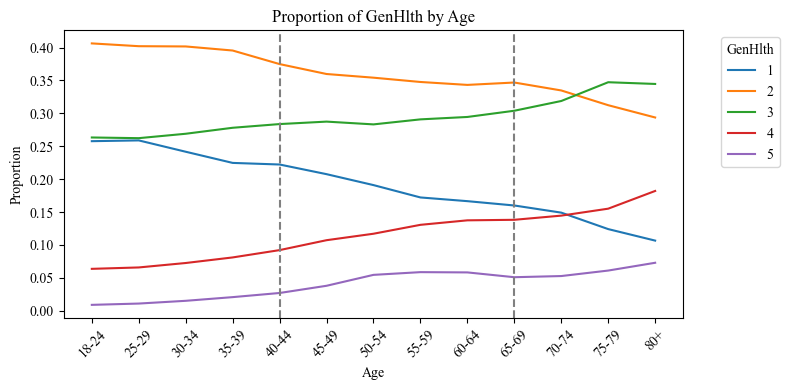

In [118]:
# plot proportions of genhlth by age group
plt.figure(figsize = (8,4))
plt.plot(sorted(data['Age'].unique()), gen1, label='1')
plt.plot(sorted(data['Age'].unique()), gen2, label='2')
plt.plot(sorted(data['Age'].unique()), gen3, label='3')
plt.plot(sorted(data['Age'].unique()), gen4, label='4')
plt.plot(sorted(data['Age'].unique()), gen5, label='5')
plt.title('Proportion of GenHlth by Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='GenHlth', bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=45)
# vertical line at 40-44
plt.axvline(x=4, color='grey', linestyle='--')
# vertical line at 65-69
plt.axvline(x=9, color='grey', linestyle='--')
plt.tight_layout()
plt.show()

In [7]:
age_group_map = {'18-24': '18-44', '25-29': '18-44', '30-34': '18-44', '35-39': '18-44', '40-44': '18-44', '45-49': '45-64', '50-54': '45-64', '55-59': '45-64', '60-64': '45-64', '65-69': '65+', '70-74': '65+', '75-79': '65+', '80+': '65+'}
data['Age Group'] = data['Age'].map(age_group_map)

# Entropy

### Functions

In [8]:
def entropy(data, y):
    probs = list(data[y].value_counts(normalize=True))

    n = len(probs)

    e_sum = 0

    for i in range(n):
        if probs[i] != 0:
            e_sum += probs[i] * np.log2(probs[i])

    return -e_sum

In [9]:
def twoway_joint_entropy(data, x1, x2):
    cross = pd.crosstab(data[x1], data[x2], margins=True, normalize='all')

    num_x1 = cross.shape[0] - 1
    num_x2 = cross.shape[1] - 1

    e_sum = 0

    for i in range(num_x1):
        for j in range(num_x2):
            if cross.iloc[i, j] != 0:
                e_sum += cross.iloc[i, j] * np.log2(cross.iloc[i, j])

    return -e_sum

In [10]:
def cond_entropy(data, y, x):
    cross = pd.crosstab(data[y], data[x], margins=True, normalize='all')

    num_response = cross.shape[0] - 1
    num_cat = cross.shape[1] - 1

    ce_sum = 0

    for i in range(num_response):
        for j in range(num_cat):
            if cross.iloc[i, j] != 0:
                ce_sum += cross.iloc[i, j] * np.log2(cross.iloc[i, j] / cross.iloc[num_response, j])

    return -ce_sum

In [41]:
def two_cond_entropy(data, y, x, z):
    cross = pd.crosstab(data[y], [data[x], data[z]], margins=True, normalize='all')

    num_response = cross.shape[0] - 1
    num_cols = cross.shape[1] - 1

    ce_sum = 0

    for i in range(num_response):
        for j in range(num_cols):
            if cross.iloc[i, j] != 0:
                ce_sum += cross.iloc[i, j] * np.log2(cross.iloc[i, j] / cross.iloc[num_response, j])

    return -ce_sum

In [87]:
def joint_cond_entropy(data, x, z, y):
    cross = pd.crosstab(data[y], [data[x], data[z]], margins=True, normalize='all')

    num_response = cross.shape[0] - 1
    num_cols = cross.shape[1] - 1

    ce_sum = 0

    for i in range(num_response):
        for j in range(num_cols):
            if cross.iloc[i, j] != 0:
                ce_sum += cross.iloc[i, j] * np.log2(cross.iloc[i, j] / cross.iloc[i, num_cols])

    return -ce_sum

In [83]:
def mutual_conditional_entropy(data, y, x):

    ce_y = entropy(data, y)
    ce_x = entropy(data, x)

    ce_y_x = cond_entropy(data, y, x)
    ce_x_y = cond_entropy(data, x, y)

    mce_y_x = (((ce_y - ce_y_x) / ce_y) + ((ce_x - ce_x_y) / ce_x)) / 2

    return mce_y_x

In [88]:
def twoway_mutual_conditional_entropy(data, y, x, z):

    h_y = entropy(data, y)
    h_xz = twoway_joint_entropy(data, x, z)

    ce_y_xz = two_cond_entropy(data, y, x, z)
    ce_xz_y = joint_cond_entropy(data, x, z, y)

    mce_y_x = (((h_y - ce_y_xz) / h_y) + ((h_xz - ce_xz_y) / h_xz)) / 2

    return mce_y_x

### Entropy Results

In [13]:
response_entropy = entropy(data, 'Response')

In [14]:
conditional_entropies = {var: cond_entropy(data, 'Response', var) for var in categorical_vars}

In [15]:
# sorted conditional entropies
sorted_conditional_entropies = dict(sorted(conditional_entropies.items(), key=lambda x: x[1], reverse=False))

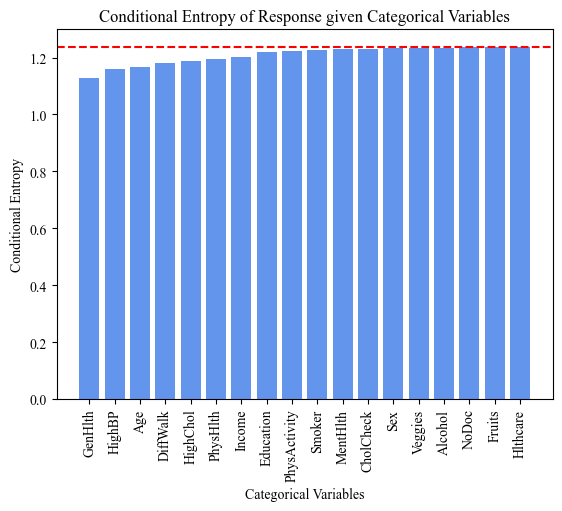

In [16]:
# bar plot of conditional entropy
plt.bar(sorted_conditional_entropies.keys(), sorted_conditional_entropies.values(), color = '#6495ed')
plt.title('Conditional Entropy of Response given Categorical Variables')
plt.xlabel('Categorical Variables')
plt.ylabel('Conditional Entropy')
plt.xticks(rotation=90)
# line for CE[Y]
plt.axhline(y=response_entropy, color='r', linestyle='--')
plt.show()

In [17]:
# mutual information
mutual_information = {var: response_entropy - cond_en for var, cond_en in conditional_entropies.items()}

In [18]:
# sorted mutual information
sorted_mutual_information = dict(sorted(mutual_information.items(), key=lambda item: item[1], reverse=True))

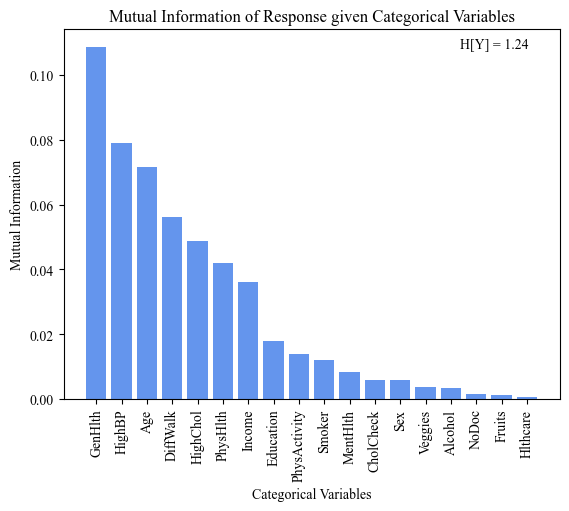

In [19]:
# bar plot of mutual information
plt.bar(sorted_mutual_information.keys(), sorted_mutual_information.values(), color = '#6495ed')
plt.title('Mutual Information of Response given Categorical Variables')
plt.xlabel('Categorical Variables')
plt.ylabel('Mutual Information')
plt.xticks(rotation=90)
plt.annotate(f'H[Y] = {response_entropy:.2f}', xy=(0, 0), xytext=(0.8, 0.95), textcoords='axes fraction')
plt.show()

In [103]:
mutual_conditional_entropies = {var: mutual_conditional_entropy(data, 'Response', var) for var in categorical_vars}
sorted_mutual_conditional_entropies = dict(sorted(mutual_conditional_entropies.items(), key=lambda x: x[1], reverse=True))

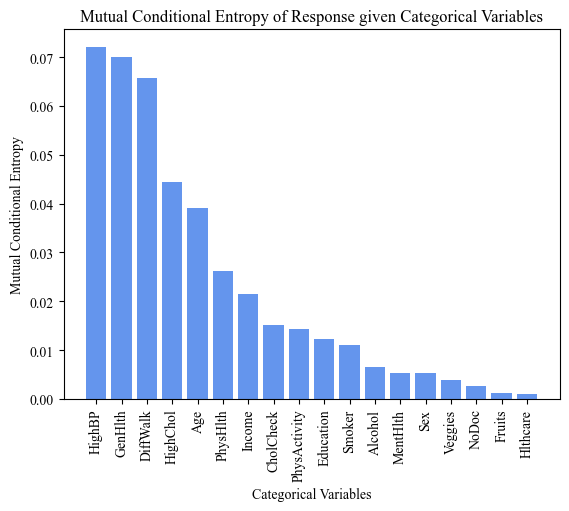

In [104]:
plt.bar(sorted_mutual_conditional_entropies.keys(), sorted_mutual_conditional_entropies.values(), color = '#6495ed')
plt.title(f'Mutual Conditional Entropy of Response given Categorical Variables')
plt.xlabel('Categorical Variables')
plt.ylabel('Mutual Conditional Entropy')
plt.xticks(rotation=90)
plt.show()

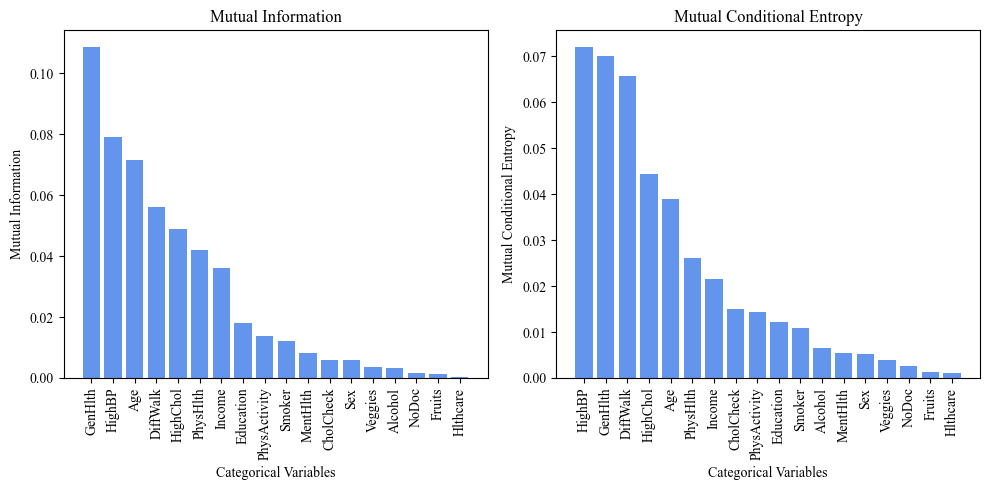

In [112]:
# side-by-side plots of mutual information and mutual conditional entropy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(sorted_mutual_information.keys(), sorted_mutual_information.values(), color = '#6495ed')
ax[0].set_title('Mutual Information')
ax[0].set_xlabel('Categorical Variables')
ax[0].set_ylabel('Mutual Information')
ax[0].xaxis.set_tick_params(rotation=90)

ax[1].bar(sorted_mutual_conditional_entropies.keys(), sorted_mutual_conditional_entropies.values(), color = '#6495ed')
ax[1].set_title(f'Mutual Conditional Entropy')
ax[1].set_xlabel('Categorical Variables')
ax[1].set_ylabel('Mutual Conditional Entropy')
ax[1].xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

### Entropy Interaction Results

In [90]:
variable_pairs = list(itertools.combinations(categorical_vars, 2))

In [57]:
# condtional entropy for all two way interactions
conditional_entropies_twoway = {f'{pair[0]} : {pair[1]}': two_cond_entropy(data, 'Response', pair[0], pair[1]) for pair in variable_pairs}
sorted_conditional_entropies_twoway = dict(sorted(conditional_entropies_twoway.items(), key=lambda x: x[1], reverse=False)[:10])

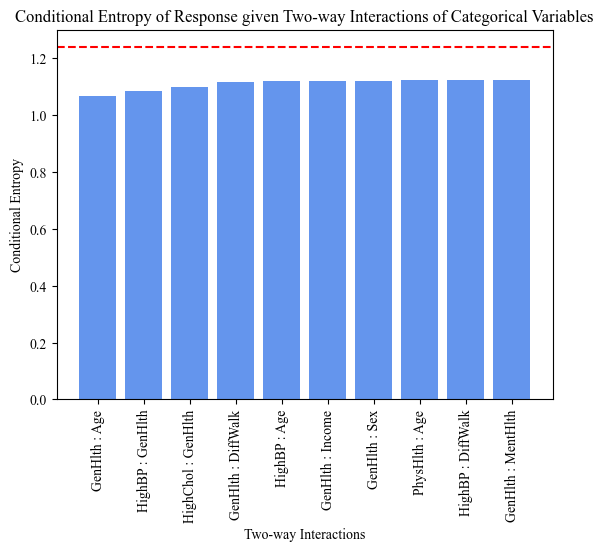

In [61]:
# plot of conditional entropy for all two way interactions
plt.bar(sorted_conditional_entropies_twoway.keys(), sorted_conditional_entropies_twoway.values(), color = '#6495ed')
plt.title('Conditional Entropy of Response given Two-way Interactions of Categorical Variables')
plt.xlabel('Two-way Interactions')
plt.ylabel('Conditional Entropy')
plt.axhline(y=response_entropy, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [81]:
# mutual information for all two way interactions
mutual_information_twoway = {pair: response_entropy - cond_en for pair, cond_en in conditional_entropies_twoway.items()}
sorted_mutual_information_twoway = dict(sorted(mutual_information_twoway.items(), key=lambda item: item[1], reverse=True)[:10])

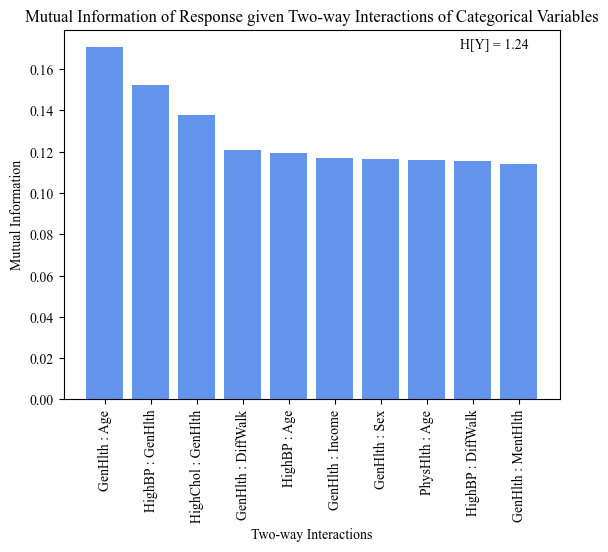

In [82]:
# plot of mutual information for all two way interactions
plt.bar(sorted_mutual_information_twoway.keys(), sorted_mutual_information_twoway.values(), color = '#6495ed')
plt.title('Mutual Information of Response given Two-way Interactions of Categorical Variables')
plt.xlabel('Two-way Interactions')
plt.ylabel('Mutual Information')
plt.xticks(rotation=90)
plt.annotate(f'H[Y] = {response_entropy:.2f}', xy=(0, 0), xytext=(0.8, 0.95), textcoords='axes fraction')
plt.show()

In [92]:
# twoway mutual conditional entropy for all interactions
twoway_mutual_conditional_entropies = {f'{pair[0]} : {pair[1]}': twoway_mutual_conditional_entropy(data, 'Response', pair[0], pair[1]) for pair in variable_pairs}
sorted_twoway_mutual_conditional_entropies = dict(sorted(twoway_mutual_conditional_entropies.items(), key=lambda x: x[1], reverse=True)[:10])

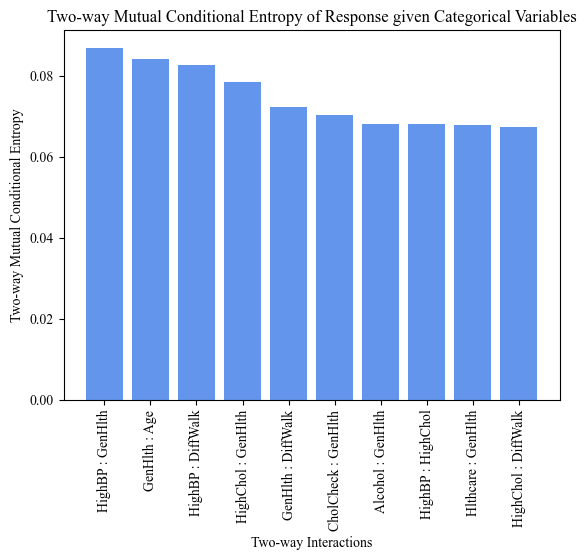

In [93]:
# plot of twoway mutual conditional entropy for all interactions
plt.bar(sorted_twoway_mutual_conditional_entropies.keys(), sorted_twoway_mutual_conditional_entropies.values(), color = '#6495ed')
plt.title('Two-way Mutual Conditional Entropy of Response given Categorical Variables')
plt.xlabel('Two-way Interactions')
plt.ylabel('Two-way Mutual Conditional Entropy')
plt.xticks(rotation=90)
plt.show()

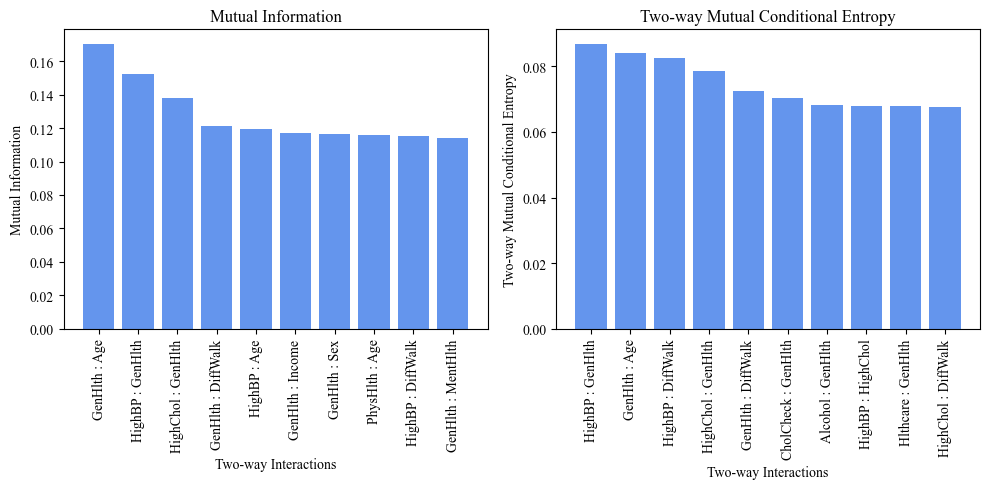

In [111]:
# side-by-side plots of mutual information and mutual conditional entropy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(sorted_mutual_information_twoway.keys(), sorted_mutual_information_twoway.values(), color = '#6495ed')
ax[0].set_title('Mutual Information')
ax[0].set_xlabel('Two-way Interactions')
ax[0].set_ylabel('Mutual Information')
ax[0].xaxis.set_tick_params(rotation=90)

ax[1].bar(sorted_twoway_mutual_conditional_entropies.keys(), sorted_twoway_mutual_conditional_entropies.values(), color = '#6495ed')
ax[1].set_title(f'Two-way Mutual Conditional Entropy')
ax[1].set_xlabel('Two-way Interactions')
ax[1].set_ylabel('Two-way Mutual Conditional Entropy')
ax[1].xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

# GenHlth and Age Sub-Populations

In [23]:
variables_of_interest = ['HighBP', 'DiffWalk', 'HighChol', 'PhysHlth', 'Income', 'CholCheck', 'PhysActivity', 'Education', 'Smoker', 'Alcohol', 'MentHlth', 'Sex', 'Veggies', 'NoDoc', 'Fruits', 'Hlthcare']

In [99]:
def plot_mutual_conditional_entropy_per_genhlth_and_age_group(data, age_group):

    data = data[data['Age Group'] == age_group]

    fig, axs = plt.subplots(1, 5, figsize=(12, 3))

    for val in sorted(data['GenHlth'].unique()):
        val = int(val)
        data_val = data[data['GenHlth'] == val]

        mutual_conditional_entropies = {var: mutual_conditional_entropy(data_val, var, 'Response') for var in variables_of_interest}

        sorted_mutual_conditional_entropies = dict(sorted(mutual_conditional_entropies.items(), key=lambda x: x[1], reverse=True)[:10])
        
        plot = axs[val-1].bar(sorted_mutual_conditional_entropies.keys(), sorted_mutual_conditional_entropies.values(), color = 'grey')

        # indices of desired variables
        # and change color
        var_lst = list(sorted_mutual_conditional_entropies.keys())
        if 'HighBP' in sorted_mutual_conditional_entropies:
            HighBP_idx = var_lst.index('HighBP')
            plot[HighBP_idx].set_color('#6495ed')
        if 'DiffWalk' in sorted_mutual_conditional_entropies:
            DiffWalk_idx = var_lst.index('DiffWalk')
            plot[DiffWalk_idx].set_color('#c387e0')
        if 'HighChol' in sorted_mutual_conditional_entropies:
            HighChol_idx = var_lst.index('HighChol')
            plot[HighChol_idx].set_color('#ff847e')
        if 'Smoker' in sorted_mutual_conditional_entropies:
            Smoker_idx = var_lst.index('Smoker')
            plot[Smoker_idx].set_color('#ffa34d')
        if 'Sex' in sorted_mutual_conditional_entropies:
            Sex_idx = var_lst.index('Sex')
            plot[Sex_idx].set_color('#fe7ab5')
                              
        axs[val-1].set_title(f' GenHlth = {val}')
        axs[val-1].xaxis.set_tick_params(rotation=90)
        
    #fig.suptitle(f'Mutual Conditional Entropy of Response given Categorical Variables for {age_group} Age Group', **csfont)
    axs[0].set_ylabel('Mutual Conditional Entropy')
    plt.tight_layout()
    plt.show()
    return

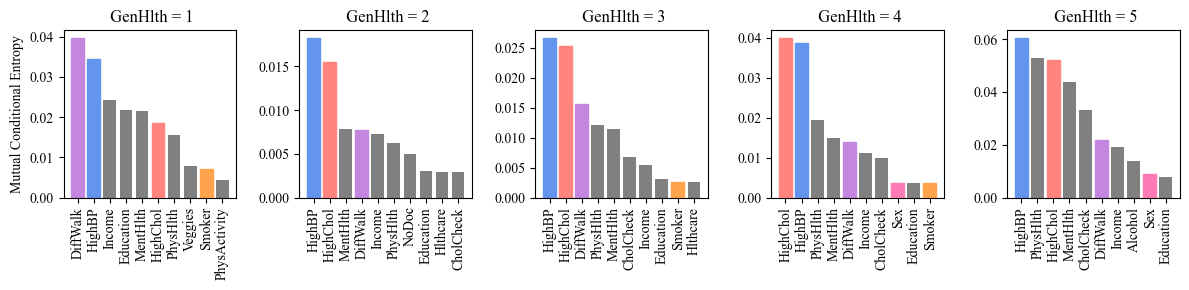

In [100]:
plot_mutual_conditional_entropy_per_genhlth_and_age_group(data, '18-44')

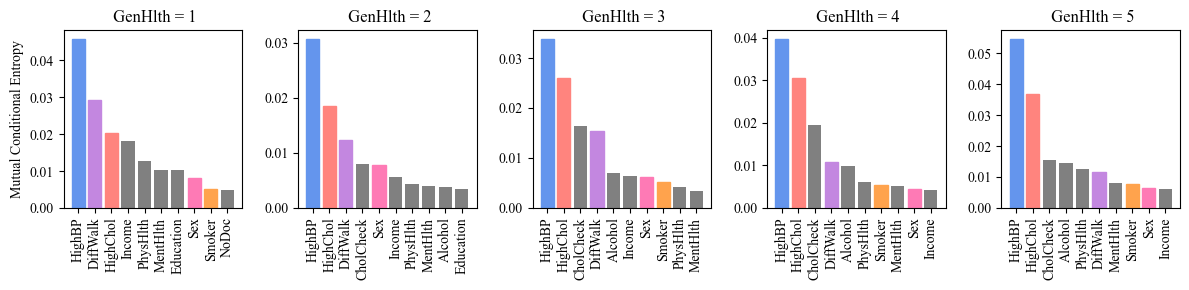

In [101]:
plot_mutual_conditional_entropy_per_genhlth_and_age_group(data, '45-64')

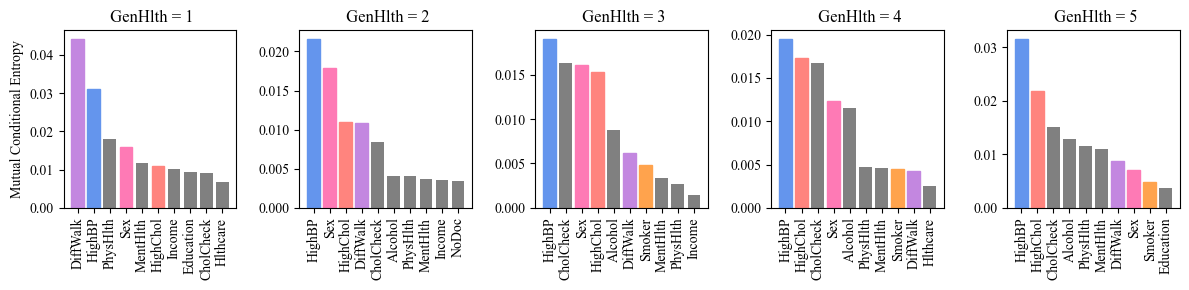

In [102]:
plot_mutual_conditional_entropy_per_genhlth_and_age_group(data, '65+')